# QUESTÃO DE NEGÓCIO

**Empresa:**

  Dirk Rossmann GmbH


**Sobre a Empresa?**

-  A Rossmann é uma das maiores cadeias de **drogarias** da **Europa**, com cerca de **56.200 funcionários** e mais de **4.000 lojas**.
Em **2019**, a Rossmann teve um faturamento de mais de **€ 10 bilhões** na Alemanha, Polônia, Hungria, República Tcheca, Turquia, Albânia, Kosovo e Espanha.


**Qual o problema de negócio?**

-  O **CFO** da empresa quer saber qual será a **previsão de venda**s das próximas **6 semanas**, de cada loja da **Rossmann** espalhadas por toda Europa, para saber qual será o **budget** destinado à **reforma** das respectivas **lojas**.


**Objetivo do desafio?**

-  O **desafio** consiste na construção de um **modelo** de aprendizado de máquina de **regressão** para realizar a **previsão de vendas** de cada **loja**.

-  Ao final, devem ser apresentados os **resultados obtidos** bem com o anexo de uma **coluna** chamada **"previsão"** com os **valores encontrados** pelo **modelo treinado**.


**Sobre os Dados:**

 * **Store:** ID único de cada Store.
 * **Sales:** A quantidade de vendas naquele dia.
 * **Customers:** A quantidade de clientes naquele dia.
 * **Date:** O dia do dado.
 * **DayOfWeek:** Dia da Semana.
 * **Open:** 0 = Loja Fechada; 1 = Loja Aberta.
 * **StateHoliday:** a = Feriado Público; b = Feriado de Páscoa; c = Natal; 0 = None.
 * **SchoolHoliday:** Indica se a Loja naquela data foi afetada pelo fechamento de escolas públicas.
 * **StoreType:** Diferencia entra os 4 tipos de modelo: a; b; c; d.
 * **Assortment:** Indica o tipo de sortimento tem a loja: a = Básico; b = Extra, c = Extendido.
 * **CompetitionDistance:** Indica a distância, em metros, do concorrente mais próximo.
 * **CompetitionOpenSince[Year/Month]:** Indica o ano e mês, aproximados, que o concorrente mais próximo abriu.
 * **Promo:** Indica se a Loja está tendo promoção naquele dia.
 * **Promo2:** Indica se a Loja tem uma promoção extendida: 1 = Loja não participante; 0 = Loja participante.
 * **Promo2Since[Year/Week]:** Descreve o ano e a semana do calendário que a Loja começou a ter promoção extendida.
 * **PromoInterval:** Descreve os 4 meses em que há promoção extendida.

No total a base de **dados** contém **1017209 linhas** com **18 colunas**.

Como **variável resposta** temos a coluna **Sales**.

**Que tipos de perguntas devemos responder?**

**1)** Quais são as **previsões de venda** para cada **loja**?

**2)** Qual o **melhor cenário** dado a previsão?

**3)** Qual o **pior cenário** dado a previsão?

# 0.0. IMPORTS

In [1]:
pip install inflection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install pycorr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import math
import json
import requests
import numpy      as np
import pandas     as pd
import seaborn    as sns
import pickle
import random
import warnings
import inflection


from datetime import timedelta
from scipy                 import stats    as ss
from boruta                import BorutaPy
from tabulate              import tabulate
from matplotlib            import pyplot   as plt
from IPython.display       import Image
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from pycorrcat.pycorrcat   import plot_corr, corr_matrix
from sklearn.linear_model  import LinearRegression, Lasso
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    b = ( chi2corr/n ) / ( min( kcorr-1, rcorr-1) )
    
    v = np.sqrt( b )
    return v

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print('\nKfold Number:{}'.format( k ) )
        
        # start and end validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop( ['sales', 'date'], axis=1 ) 
        ytraining = training['sales']

        xvalidation = validation.drop( ['sales', 'date'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2. Loading data

In [8]:
df_sales_raw = pd.read_csv( '/content/drive/MyDrive/Colab/data/rossmann/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '/content/drive/MyDrive/Colab/data/rossmann/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [9]:
df1 = df_raw.copy()

In [10]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1. Rename Columns

In [11]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [12]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [13]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [15]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [17]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [18]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [19]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


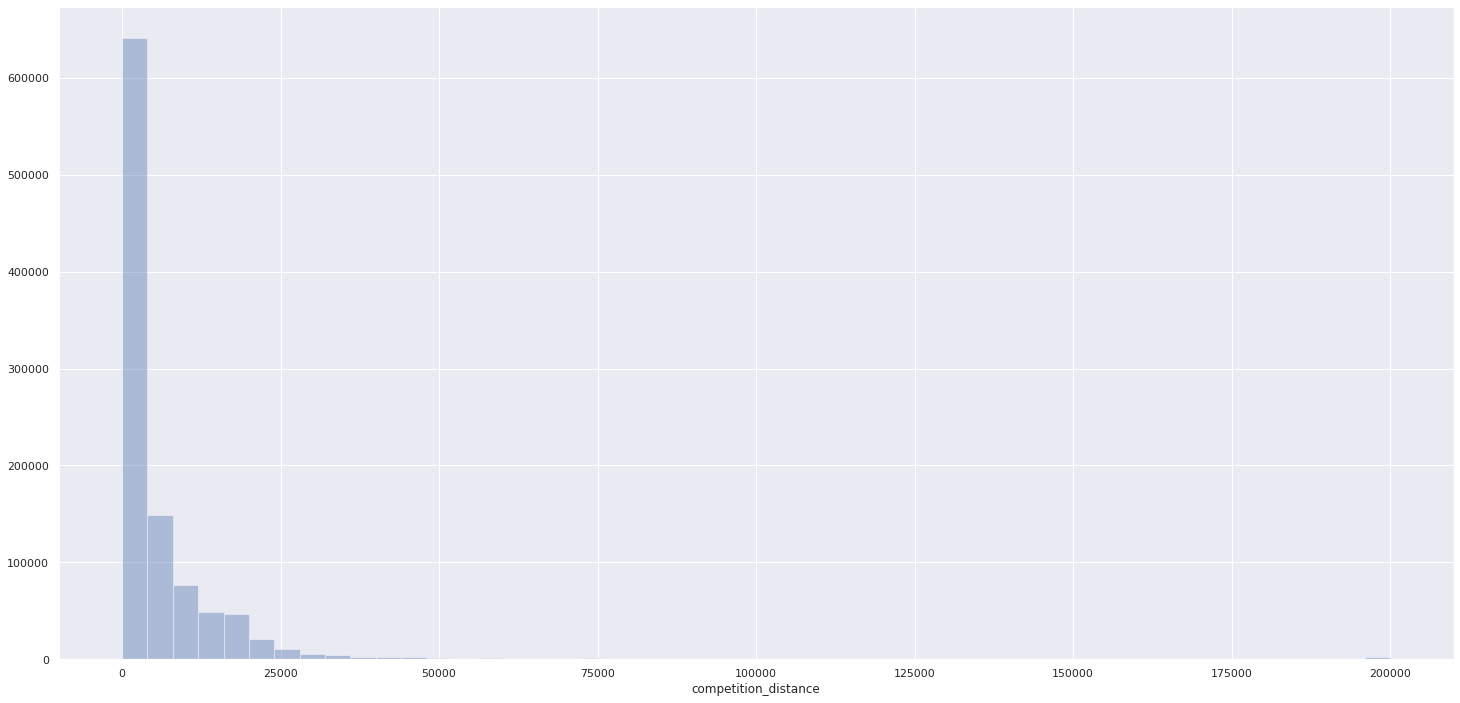

In [20]:
sns.distplot( df1['competition_distance'], kde=False )

### 1.7.2. Categorical Atributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

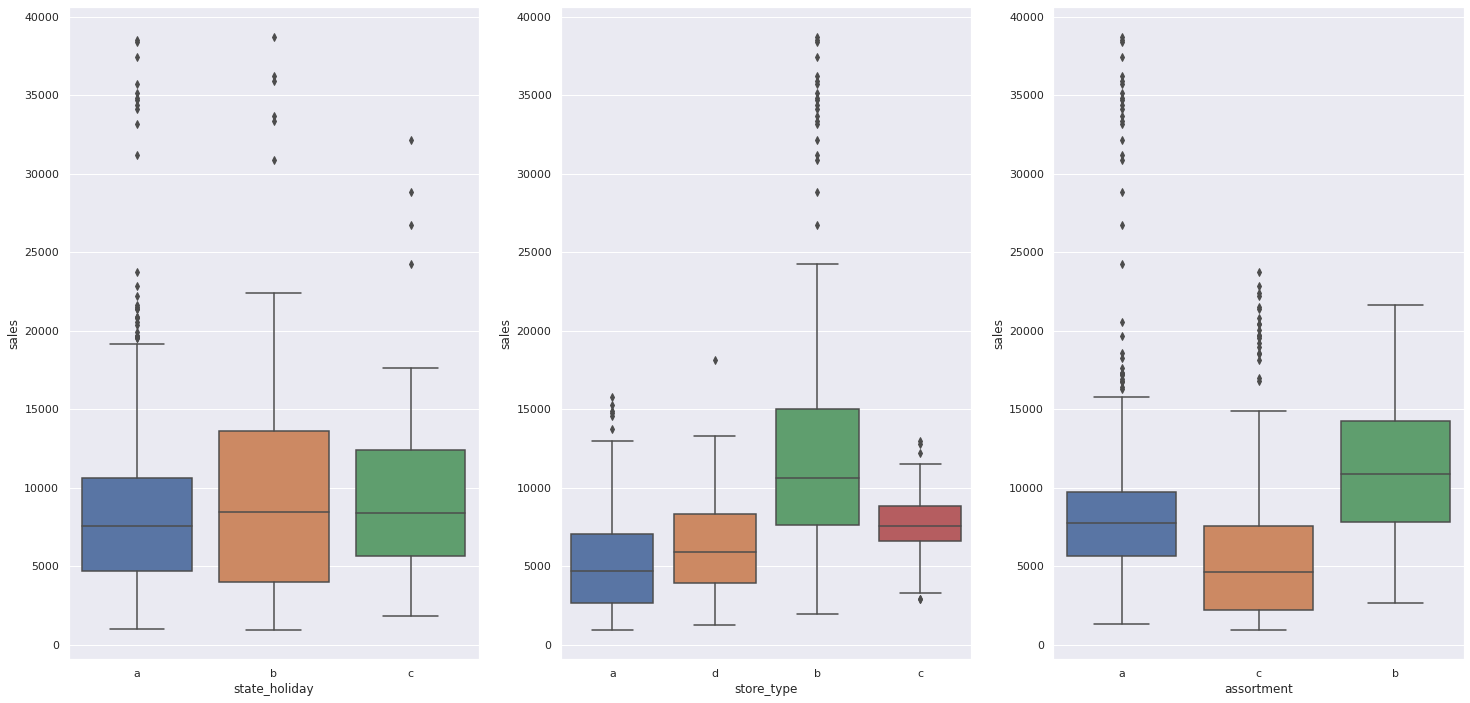

In [22]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

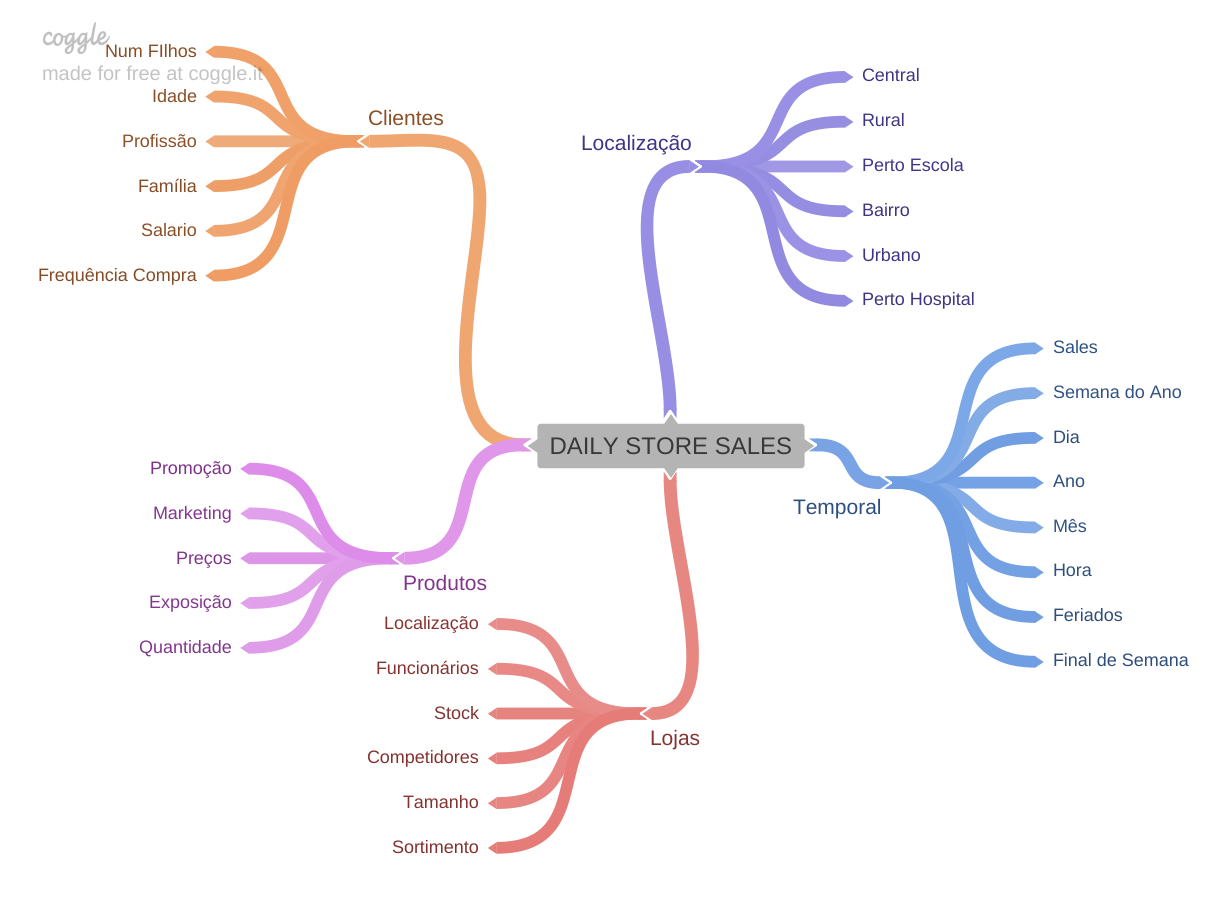

In [24]:
Image('/content/drive/MyDrive/Colab/img/rossmann/MindMapHypotesis.png')

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas


In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. PASSO 04 - ANALISE EXPLORATÓRIA DE DADOS

In [30]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


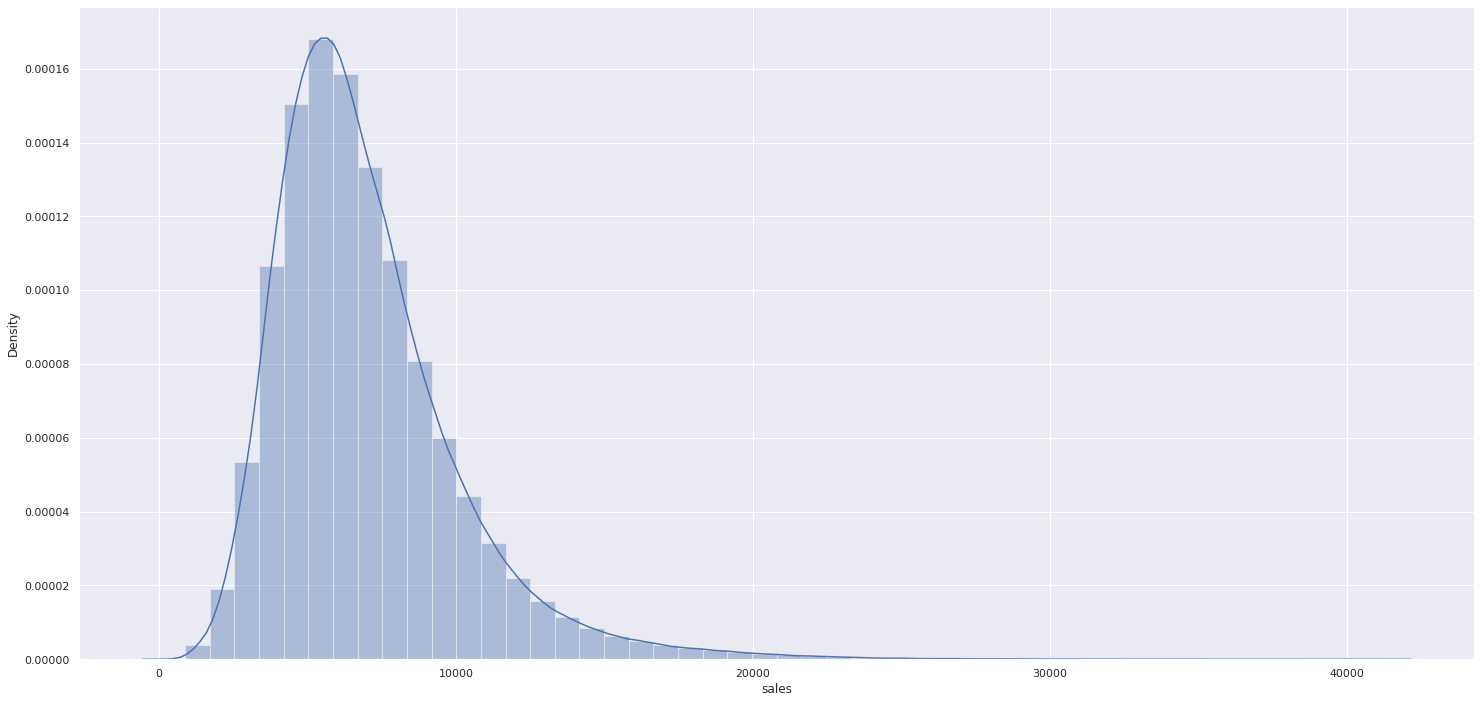

In [31]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

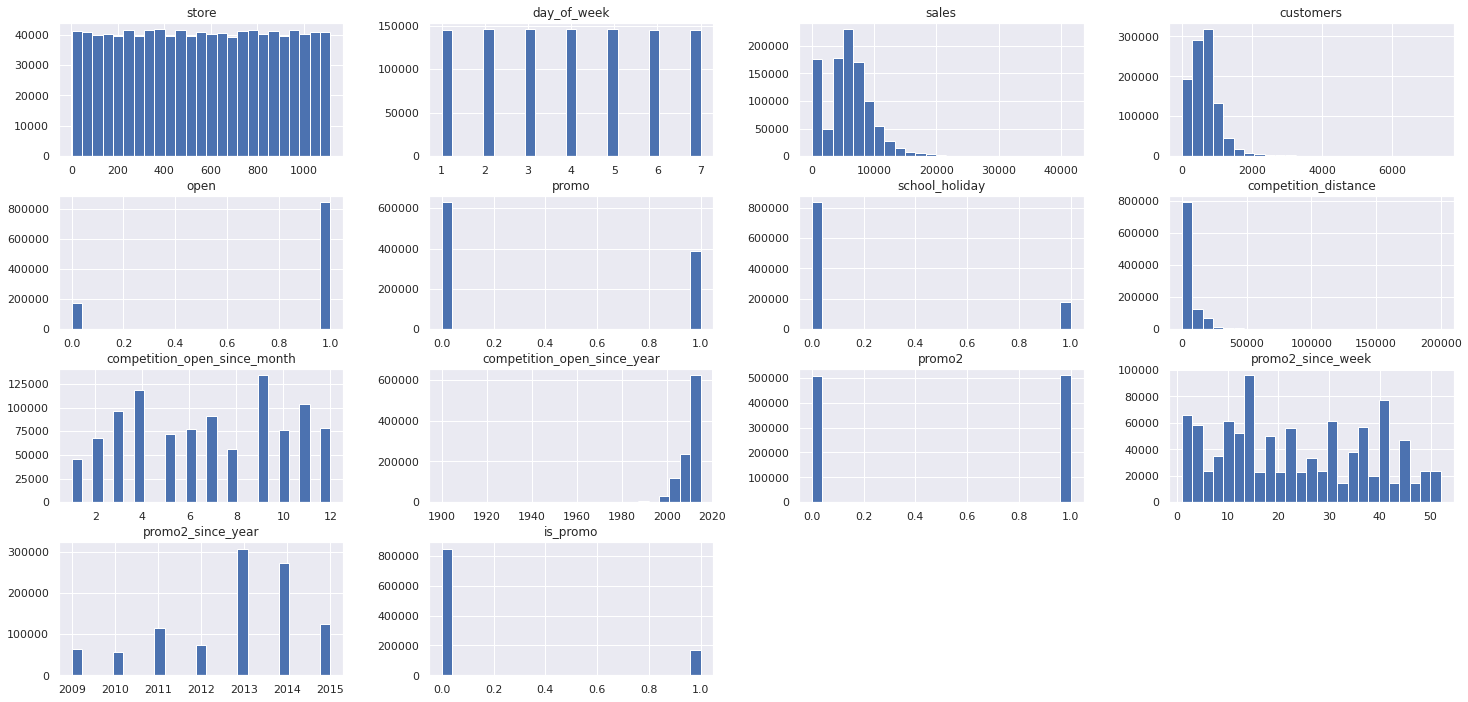

In [32]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


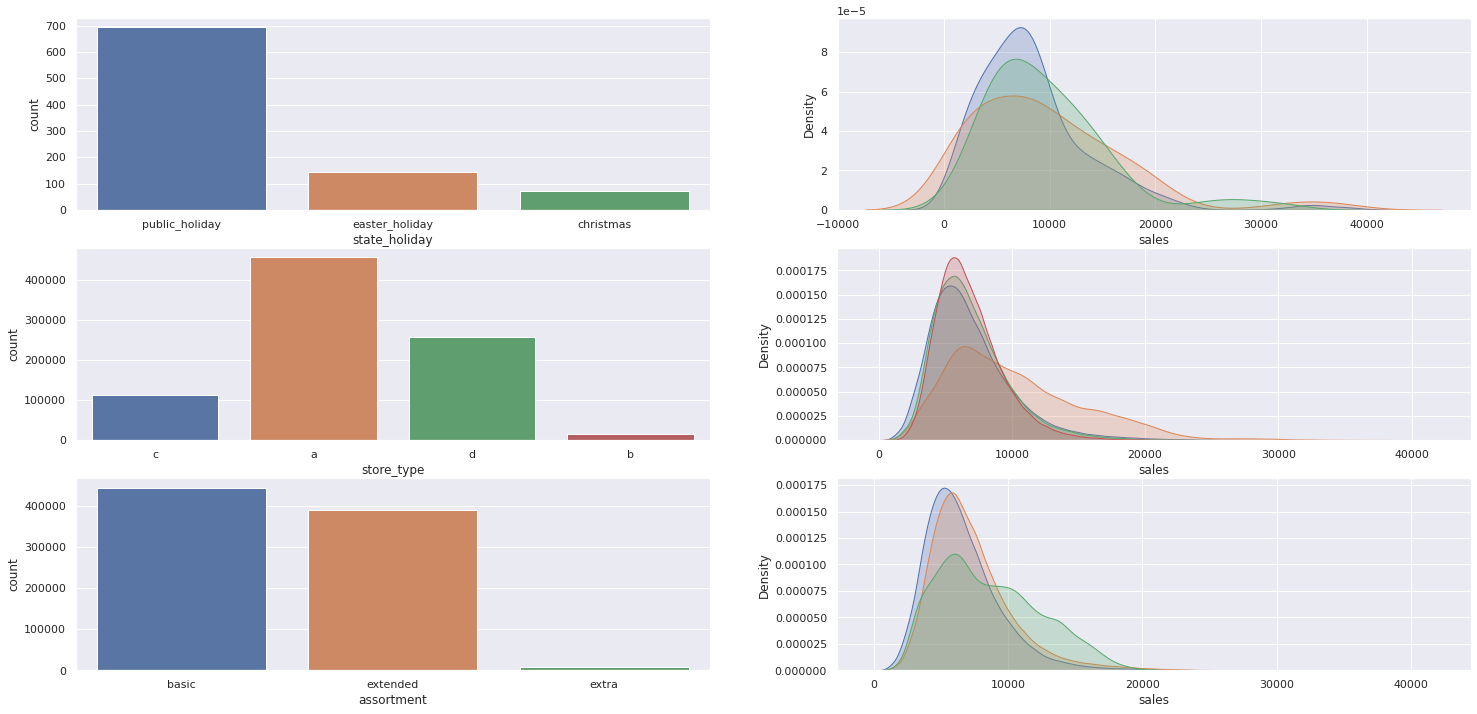

In [34]:
# state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label ='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label ='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label ='christmas', shade=True)


# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label ='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label ='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label ='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label ='d', shade=True)


# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label ='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label ='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label ='extra', shade=True)

## 4.2. Analise Bivariada

### 1. Lojas com maior sortimentos deveriam vender mais.

**FALSA**

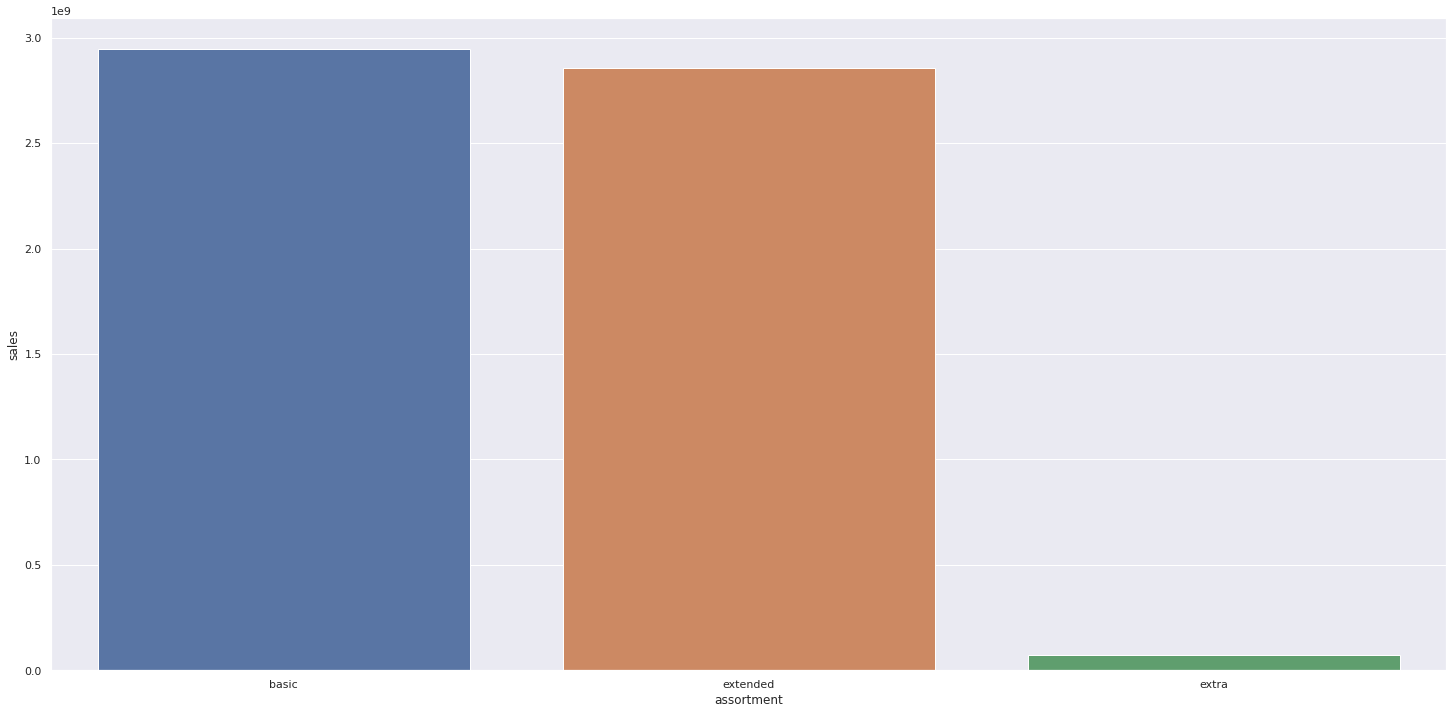

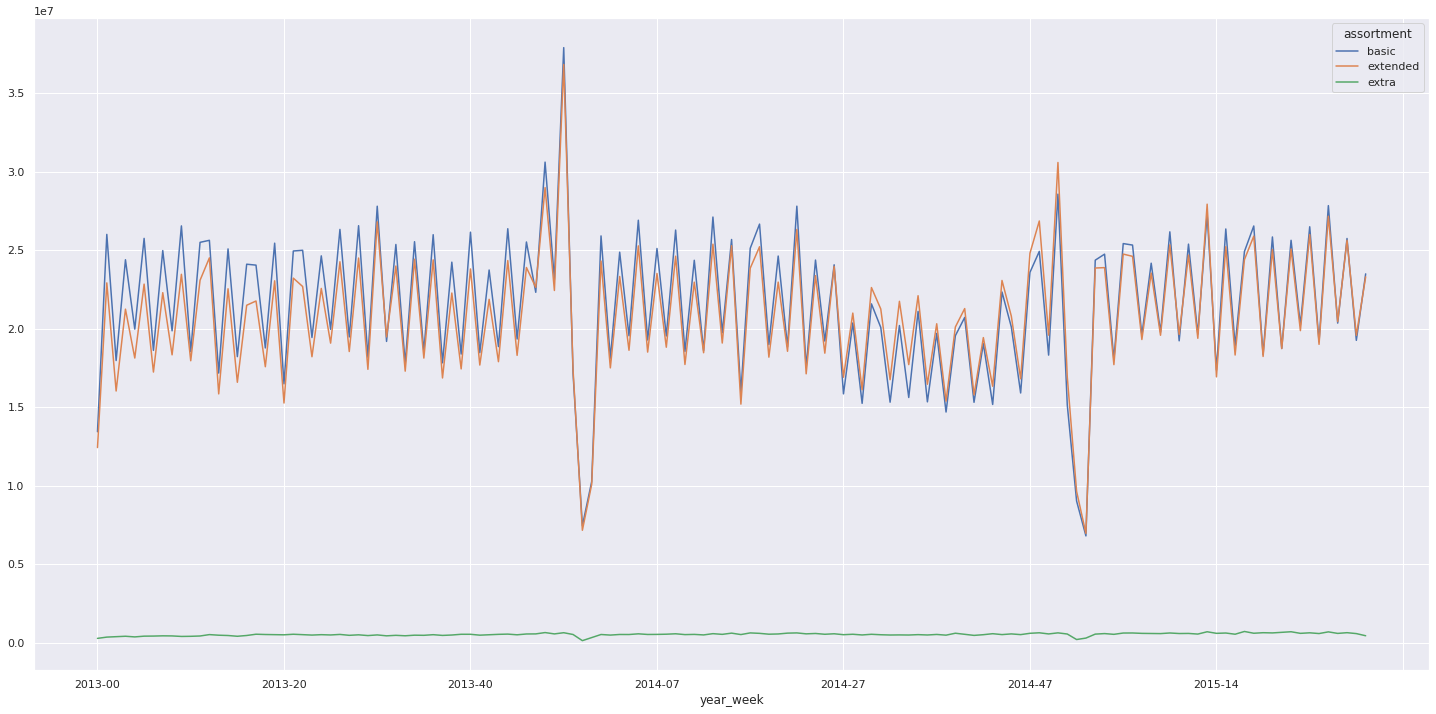

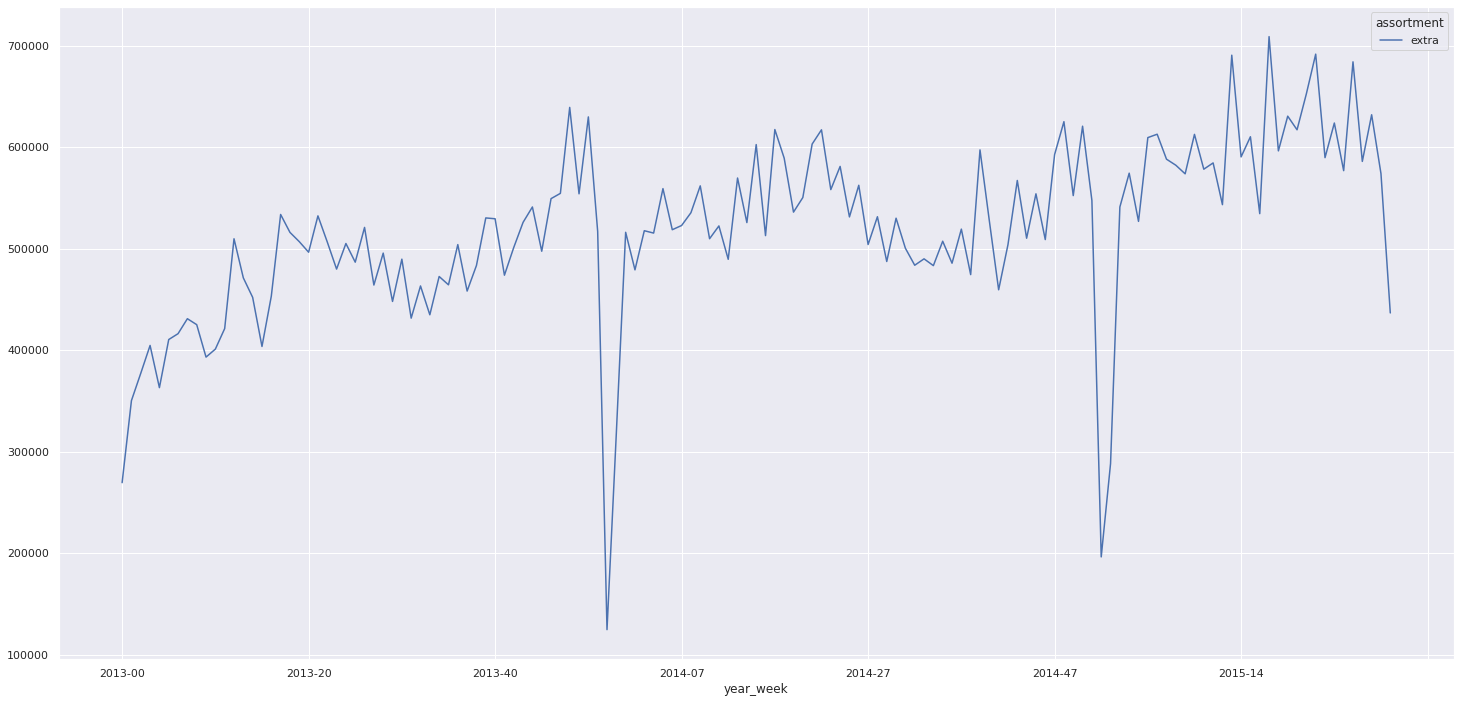

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### 2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA**

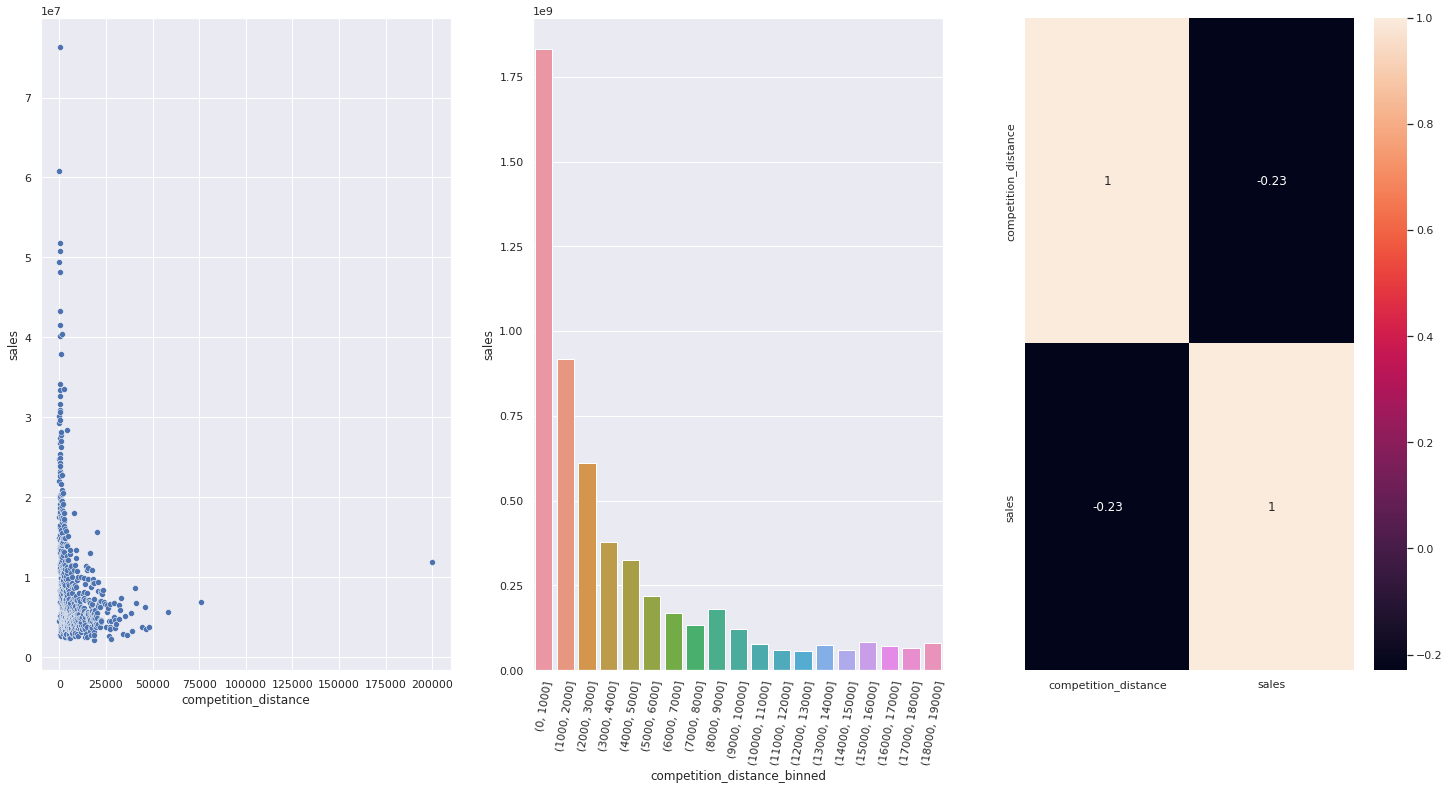

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks(rotation=80)

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA**

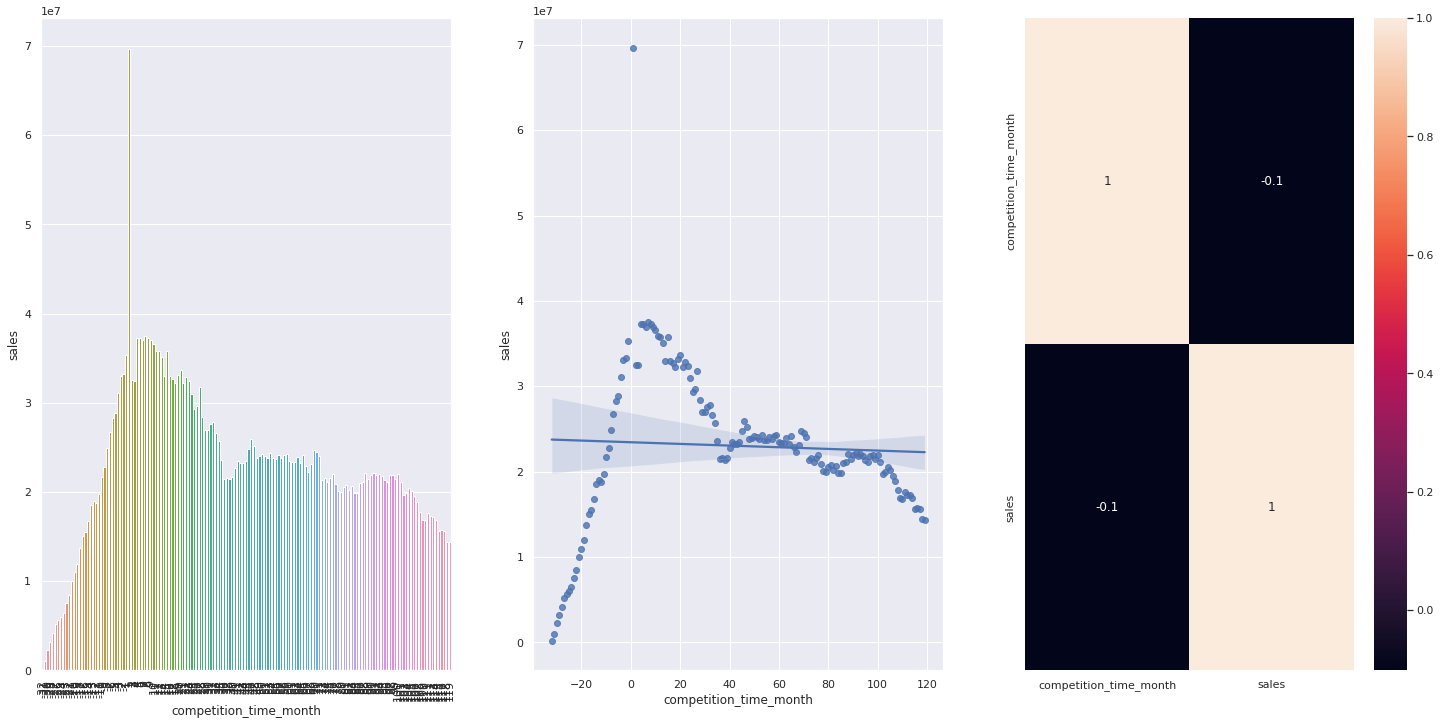

In [37]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );


### **4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA**

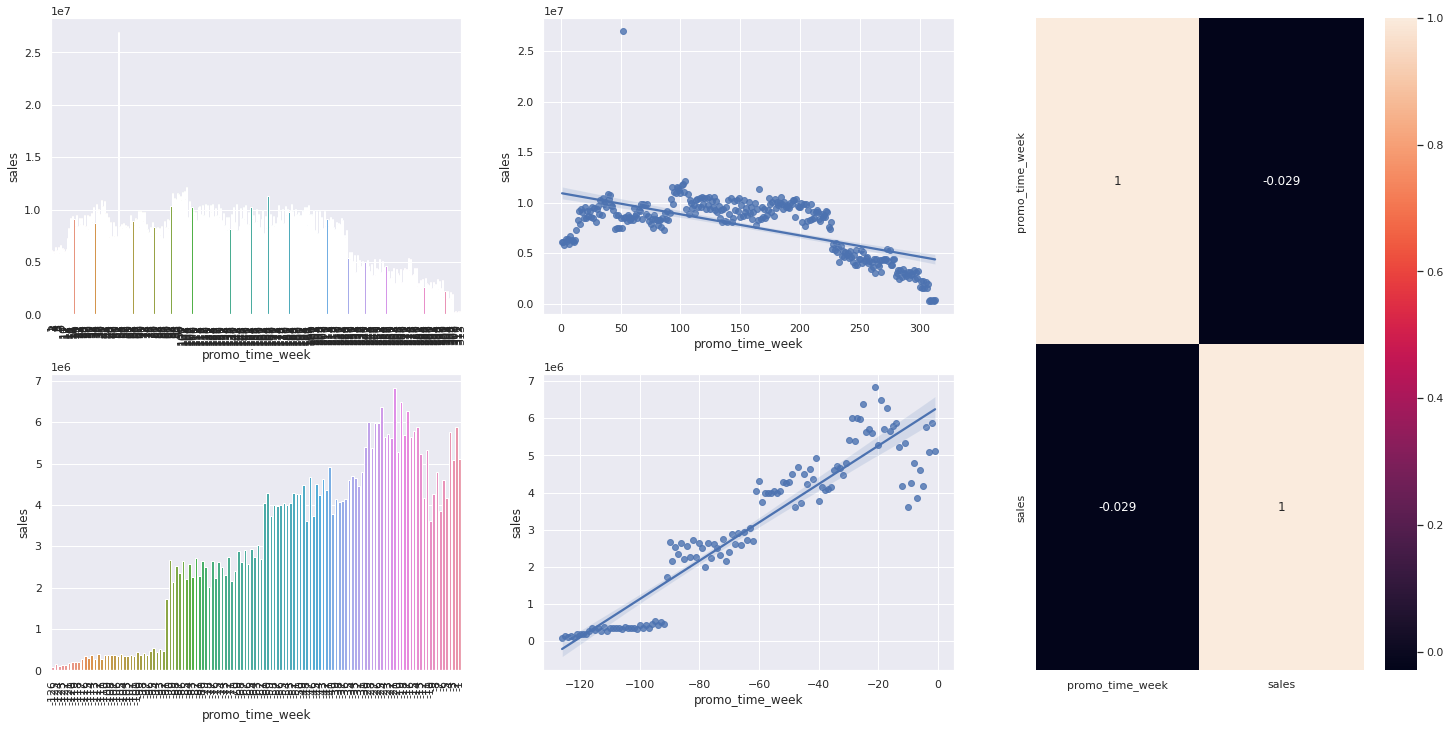

In [38]:
aux1 = df4[['promo_time_week','sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### <s>**5.** Lojas com mais dias de promoção deveriam vender mais.</s>


### **7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA**

In [39]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


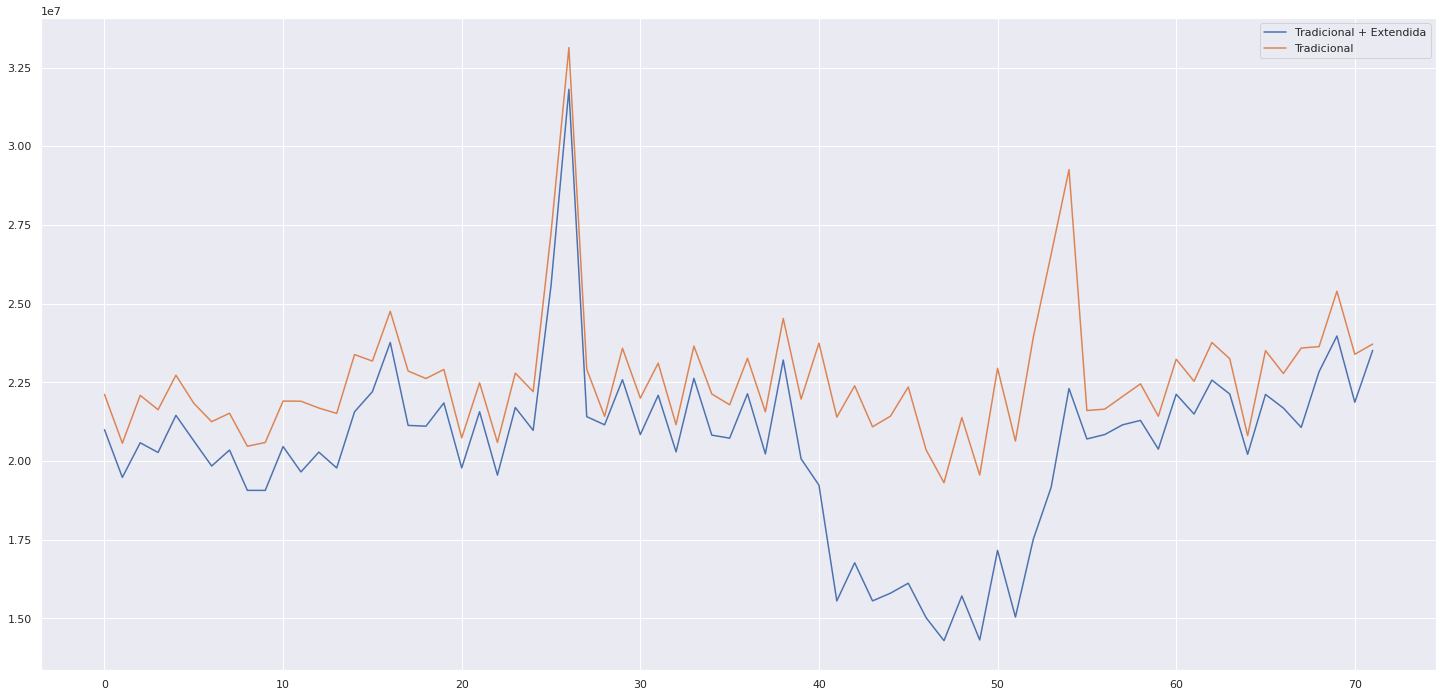

In [40]:
aux1 = df4[( df4['promo'] == 1 ) & (df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional + Extendida', 'Tradicional'] );

### **8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA**

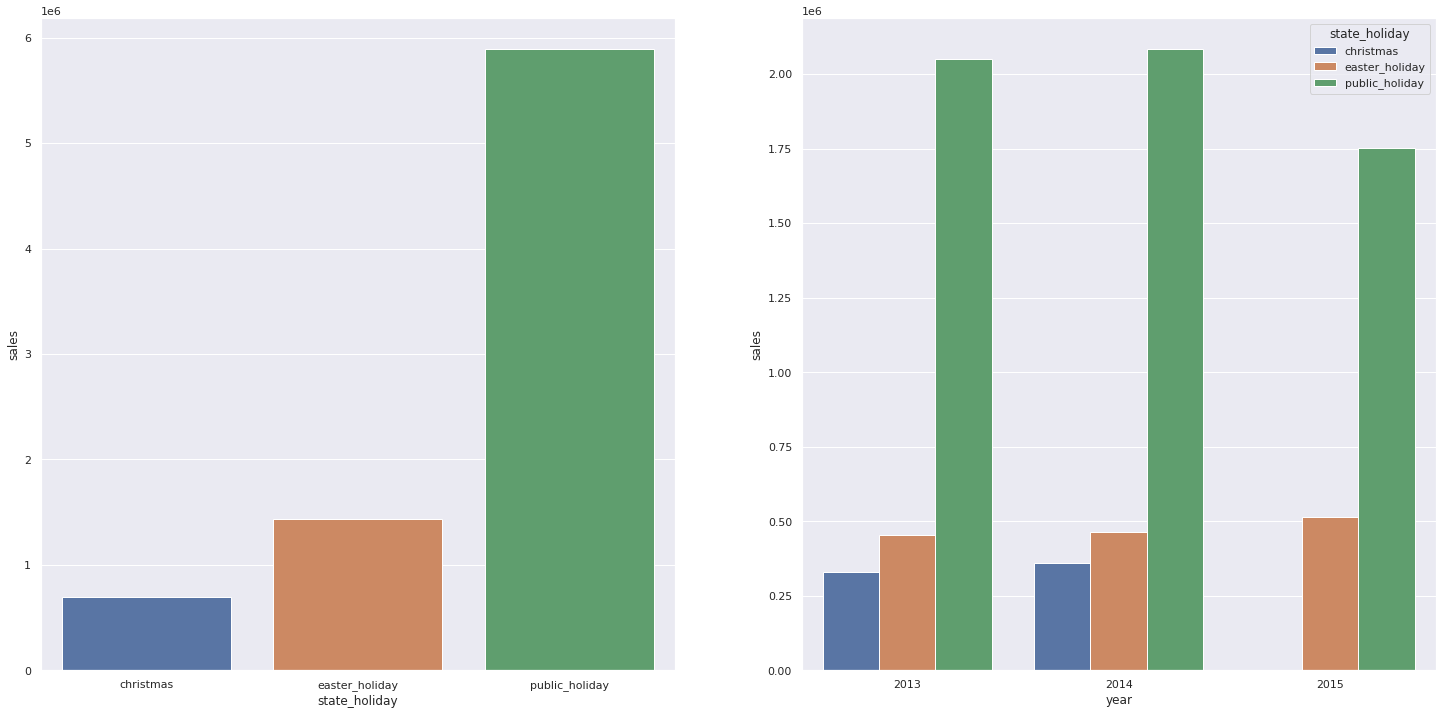

In [41]:
plt.subplot( 1, 2, 1 );
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 );
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### **9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA**

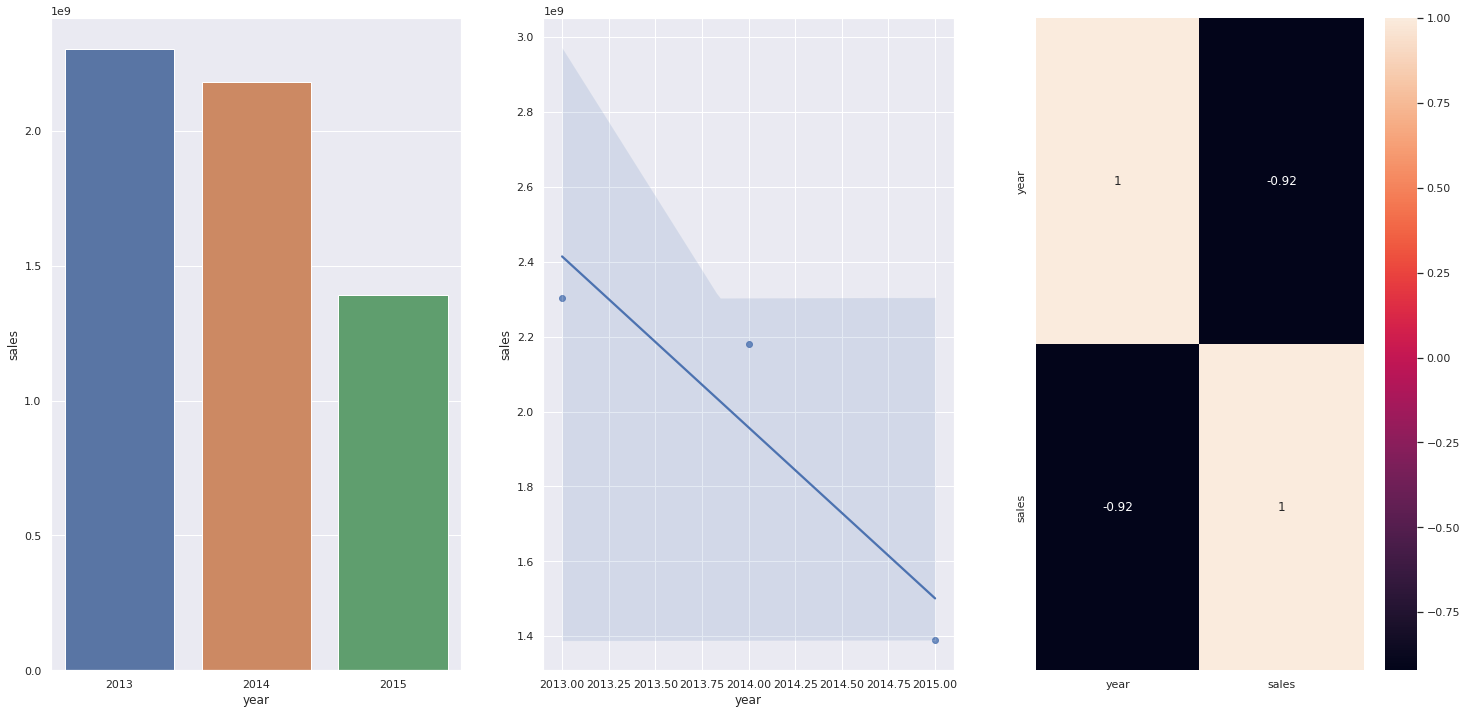

In [42]:
plt.subplot( 1, 3, 1 );
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 );
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 );
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**

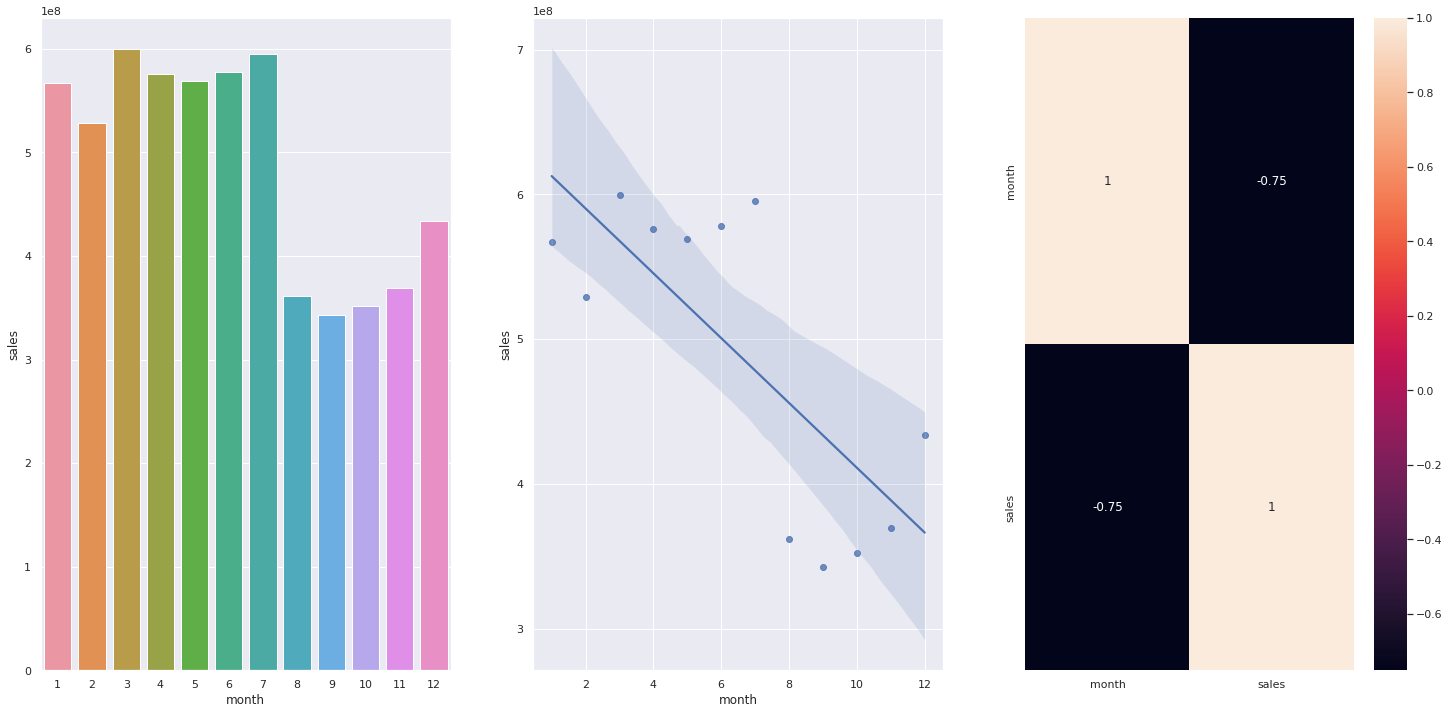

In [43]:
plt.subplot( 1, 3, 1 );
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 );
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 );
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**

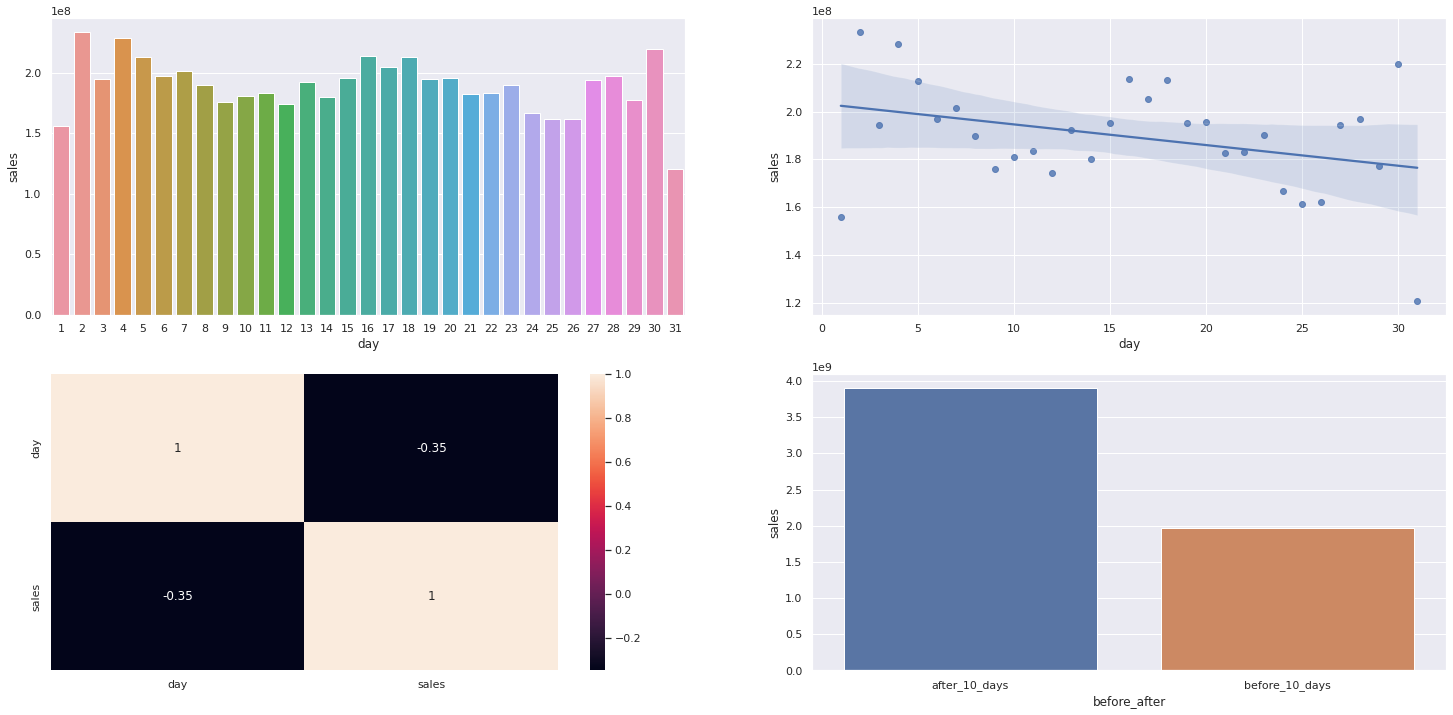

In [44]:
plt.subplot( 2, 2, 1 );
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 );
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 );
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x<= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 );
sns.barplot( x='before_after', y='sales', data=aux2 );

### **12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**

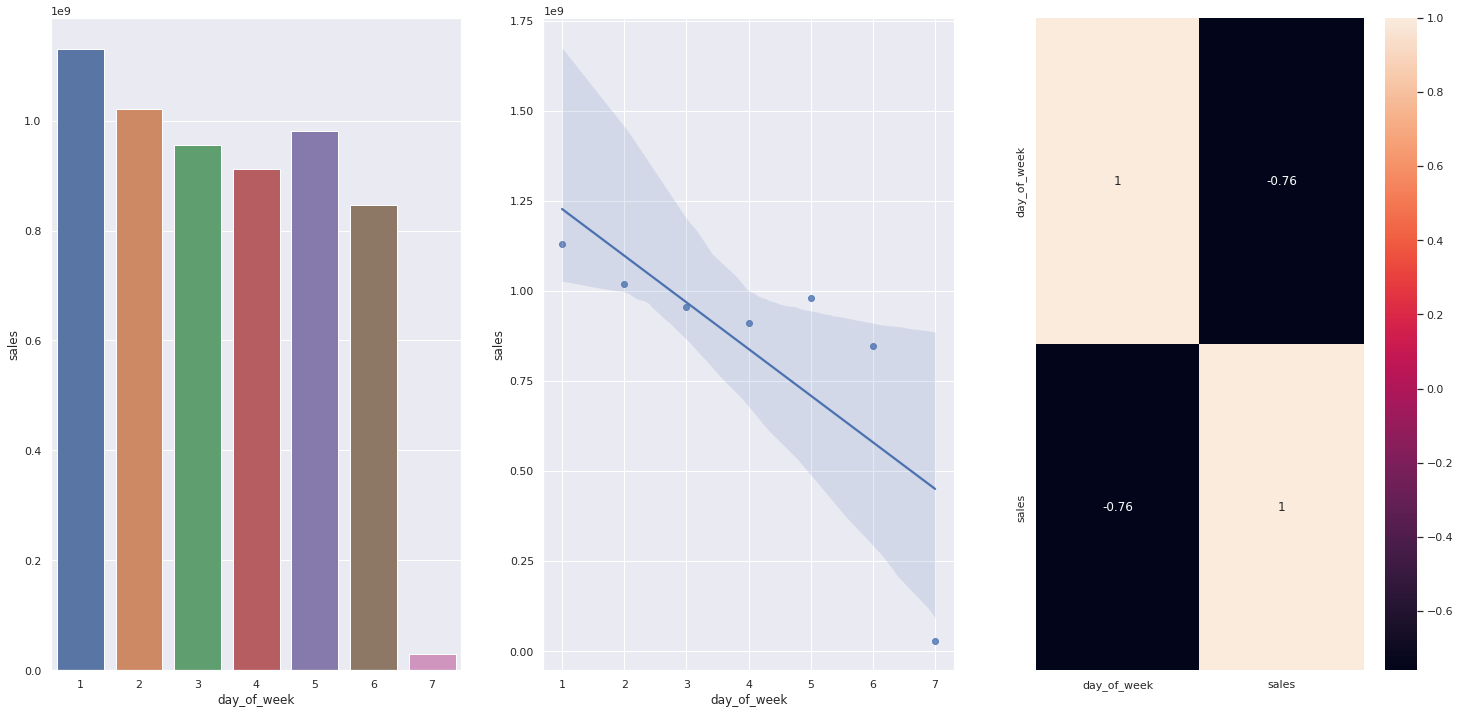

In [45]:
plt.subplot( 1, 3, 1 );
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 );
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 );
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Vendem menos exceto nos meses de julho e agosto

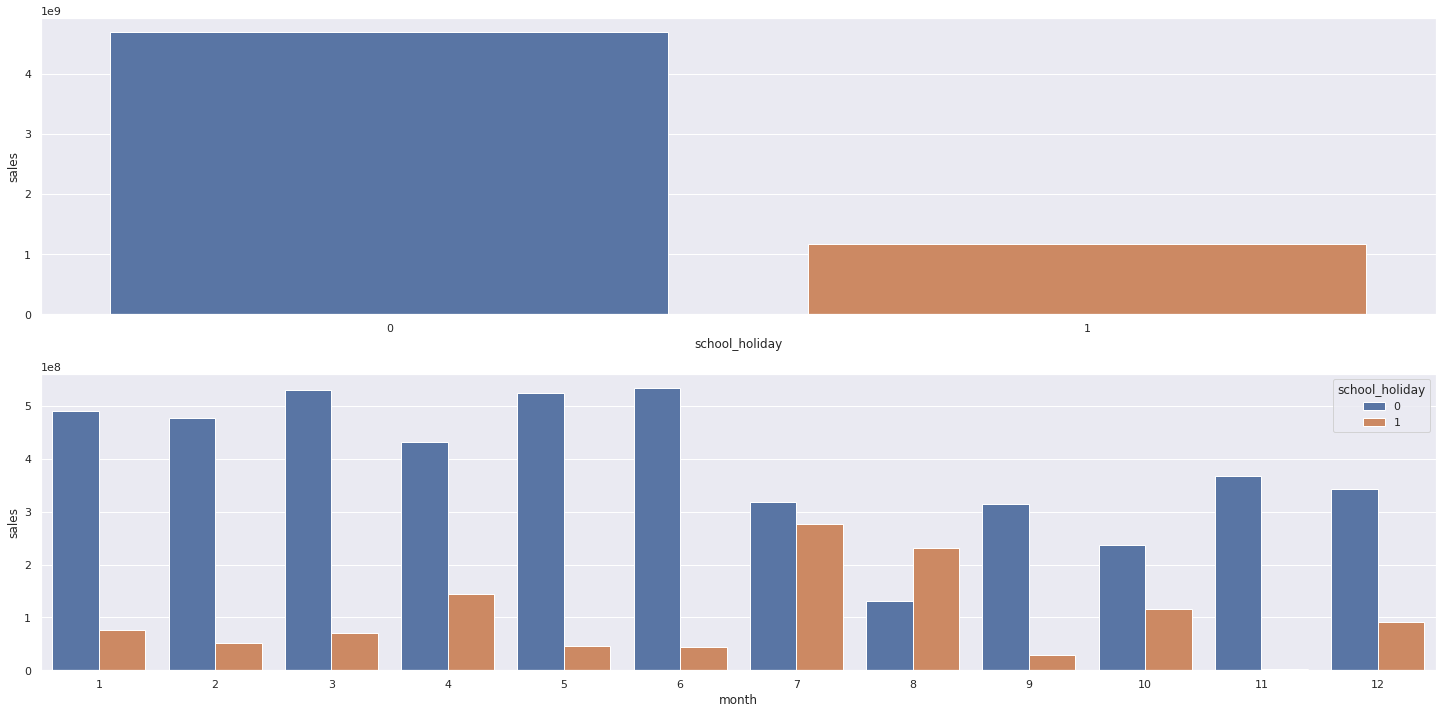

In [46]:
plt.subplot( 2, 1, 1 );
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

## Resumo das Hipóteses

In [47]:
tab = [['Hipoteses', 'Conclusao', 'Relevância'],
      ['H1', 'falsa', 'baixa'],
      ['H2', 'falsa', 'media'],
      ['H3', 'falsa', 'media'],
      ['H4', 'falsa', 'baixa'],
      ['H5', '-', '-'],
      ['H7', 'falsa', 'baixa'],
      ['H8', 'falsa', 'media'],
      ['H9', 'falsa', 'alta'],
      ['H10', 'falsa', 'alta'],
      ['H11', 'verdadeira', 'alta'],
      ['H12', 'verdadeira', 'alta'],
      ['H13', 'verdadeira', 'baixa']]

print( tabulate( tab, headers='firstrow'))

Hipoteses    Conclusao    Relevância
-----------  -----------  ------------
H1           falsa        baixa
H2           falsa        media
H3           falsa        media
H4           falsa        baixa
H5           -            -
H7           falsa        baixa
H8           falsa        media
H9           falsa        alta
H10          falsa        alta
H11          verdadeira   alta
H12          verdadeira   alta
H13          verdadeira   baixa


## 4.3. Analise Multivariada

### 4.3.1 Numerical Attributes

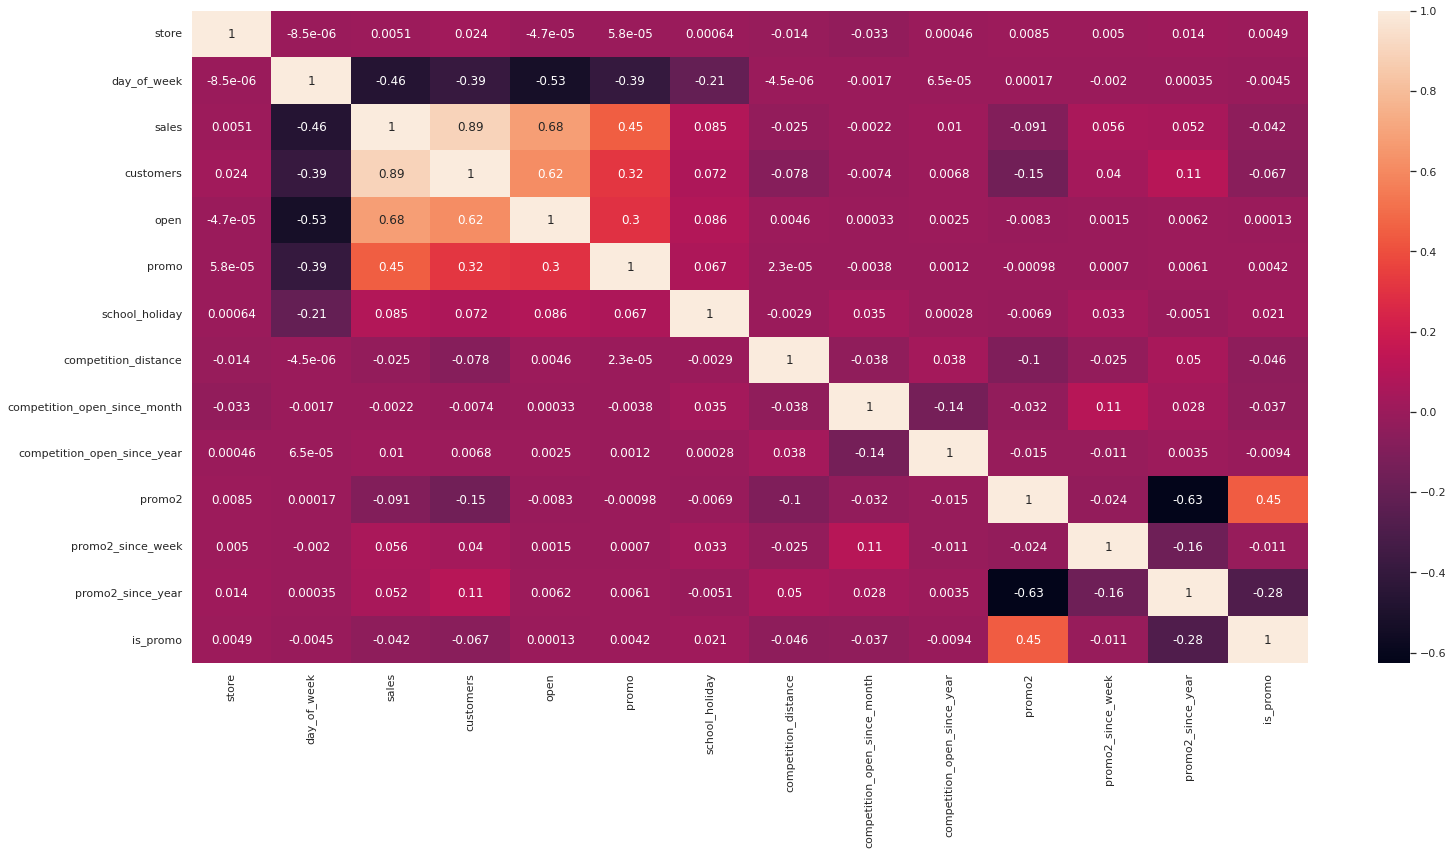

In [48]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2 Categorical Attributes

In [49]:
a = df4.select_dtypes( include='object' )

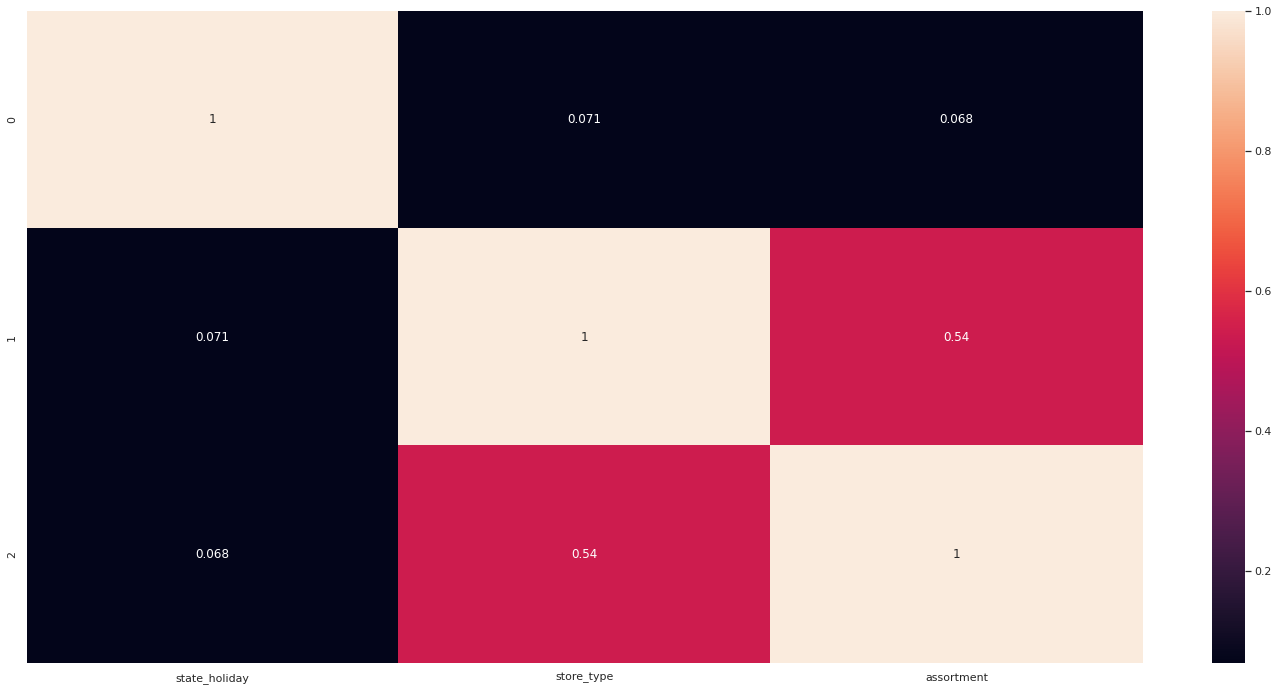

In [50]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] })
d.set_index( d.columns )

sns.heatmap( d, annot=True);


In [51]:
correlation_matrix = corr_matrix(df4, ['state_holiday', 'store_type', 'assortment'])

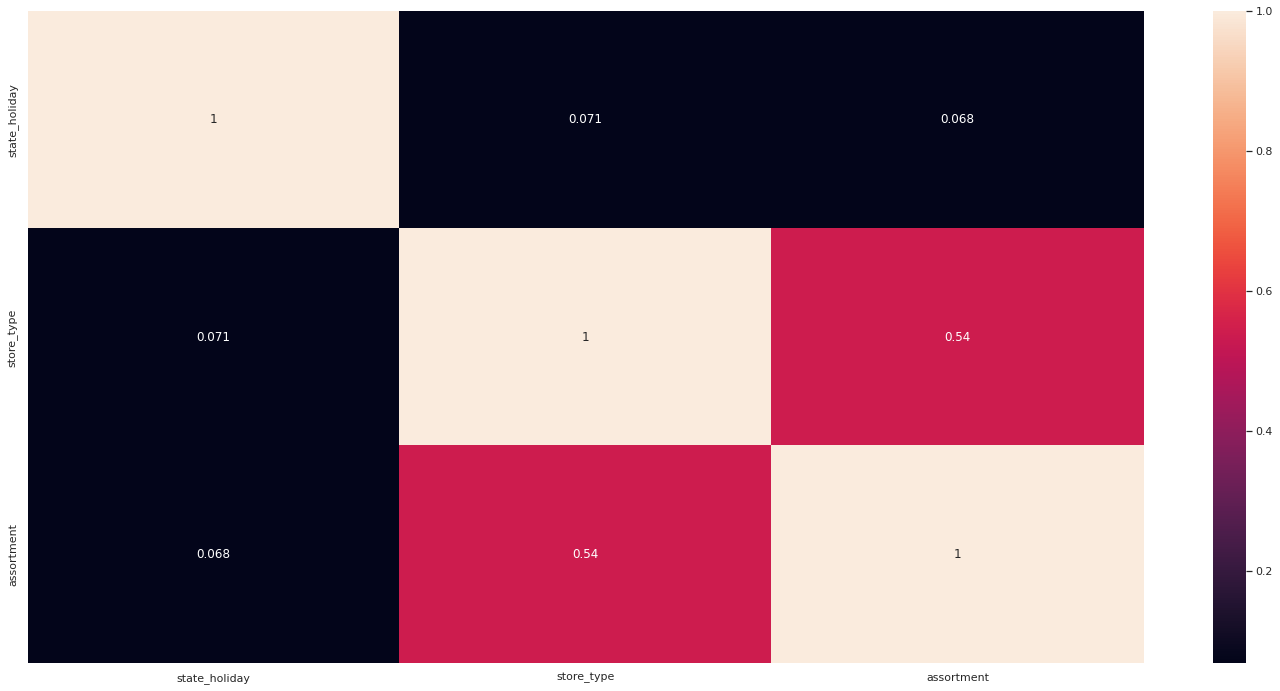

In [52]:
plot_corr(df4, ['state_holiday', 'store_type', 'assortment'] );

# 5.0. PASSO 05 - DATA PREPARATION

In [53]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
# pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
# pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

## 5.3 Transformação

### 5.3.1 Encoding

In [55]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
# pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict )


### 5.3.2 Respose Variable Transformation

In [56]:
df5['sales'] = np.log1p( df5['sales'] )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


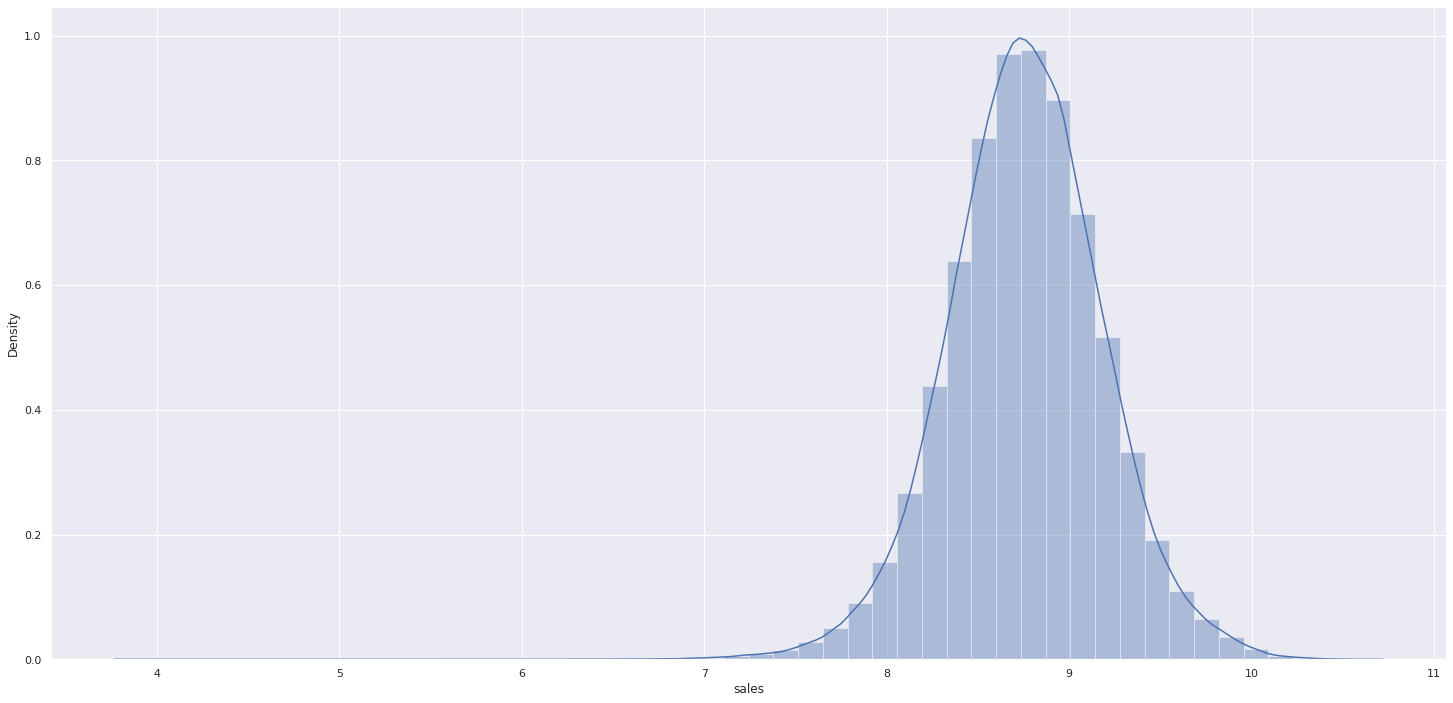

In [57]:
sns.distplot( df5['sales'] )

### 5.3.3 Nature Transformation

In [58]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52) ) )


In [59]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [60]:
df6 = df5.copy()
# df6 = pd.read_csv( '/home/jocafneto/repositorio/rossmann/df6_complete.csv', low_memory=False )

In [61]:
# df6 = df6.drop( 'Unnamed: 0', axis=1)

In [62]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.1 Splitting dataframe into training and test dataset

In [63]:
cols_drop = ['week_of_year', 'day_of_week', 'day', 'month', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [64]:
# df6['date'] = pd.to_datetime( df6['date'] )
# df6.dtypes

In [65]:
# df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

In [66]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training min date: {}'.format( X_train['date'].min() ) )
print( 'Training max date: {}'.format( X_train['date'].max() ) )

print( 'Testing min date: {}'.format( X_test['date'].min() ) )
print( 'Testing max date: {}'.format( X_test['date'].max() ) )

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00
Testing min date: 2015-06-19 00:00:00
Testing max date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [67]:
# # training and test dataset for Boruta
# x_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define boruta 
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [68]:
# cols_selected = boruta.support_.tolist()

# # best features
# x_train_fs = x_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [69]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

cols_not_selected_boruta = ['is_promo',
                            'school_holiday',
                            'state_holiday_christmas',
                            'state_holiday_easter_holiday',
                            'state_holiday_public_holiday',
                            'state_holiday_regular_day',
                            'year']

# columns to add
feature_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feature_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELING

In [70]:
df7 = df6.copy()

In [71]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]


## 7.1 Average Model

In [72]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performances
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [73]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [74]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

In [75]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model

In [76]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Cross Validation

In [77]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )

In [78]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor (non linear)

In [79]:
# model
rf = RandomForestRegressor( n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


### 7.4.1 Random Forest Regressor Model - Cross Validation

In [80]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose=True )


Kfold Number:5

Kfold Number:4

Kfold Number:3

Kfold Number:2

Kfold Number:1


In [81]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5 XGBoost Regressor (non linear)

In [82]:
from pandas import MultiIndex, Int64Index
import xgboost as xgb

In [83]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112293,0.122609,1250.952637


### 7.5.1 XGBoost Regressor Model - Cross Validation

In [84]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )


Kfold Number:5

Kfold Number:4

Kfold Number:3

Kfold Number:2

Kfold Number:1


In [85]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [86]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,843.112293,0.122609,1250.952637
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [87]:
modelling_result = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
# modelling_result = pd.concat( [lr_result_cv, lrr_result_cv] )
modelling_result.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [88]:
warnings.filterwarnings( 'ignore' )

In [89]:
param = {'n_estimators': [15, 17, 25, 30, 35],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytee': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL=2

## 8.2 Final Model

In [90]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                   eta=0.01,
                                   max_depth=10,
                                   subsample=0.7,
                                   colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) ) 
xgb_result_tuned

# pickle.dump(model_xgb_tuned, open( '/home/jocafneto/repositorio/rossmann/model/model_rossmann.pkl', 'wb' ))

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112293,0.122609,1250.952637


In [91]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [92]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [93]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [94]:
df92.sort_values( 'MAPE', ascending=True ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
489,490,290068.468750,289616.558396,290520.379104,451.910354,0.054523
345,346,273010.968750,272592.894518,273429.042982,418.074232,0.056699
741,742,288870.656250,288372.981142,289368.331358,497.675108,0.057447
762,763,234478.703125,234124.688199,234832.718051,354.014926,0.058138
310,311,254381.562500,253963.256229,254799.868771,418.306271,0.060062


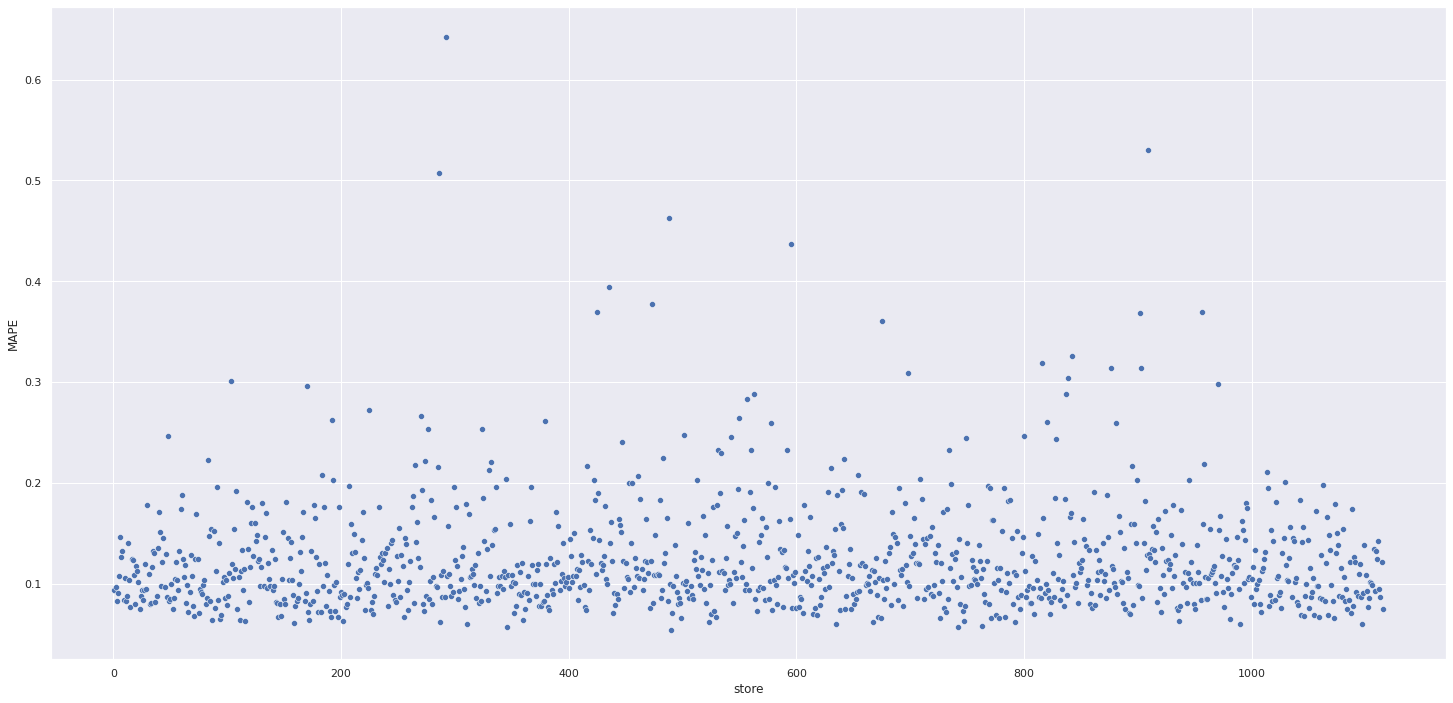

In [95]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2 Total Performance

In [96]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index':'Scenarios', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenarios,Values
0,predictions,"R$281,029,504.00"
1,worst_scenario,"R$280,086,794.85"
2,best_scenario,"R$281,972,222.57"


## 9.3 Machine Learning Performance

In [97]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [98]:
df9[['sales', 'predictions', 'error', 'error_rate']].head()

,sales,predictions,error,error_rate
0,5263.0,6063.058105,-800.058105,1.152016
1,6064.0,6559.312500,-495.312500,1.081681
2,8314.0,9313.814453,-999.814453,1.120257
3,13995.0,11633.738281,2361.261719,0.831278
4,4822.0,6959.491211,-2137.491211,1.443279


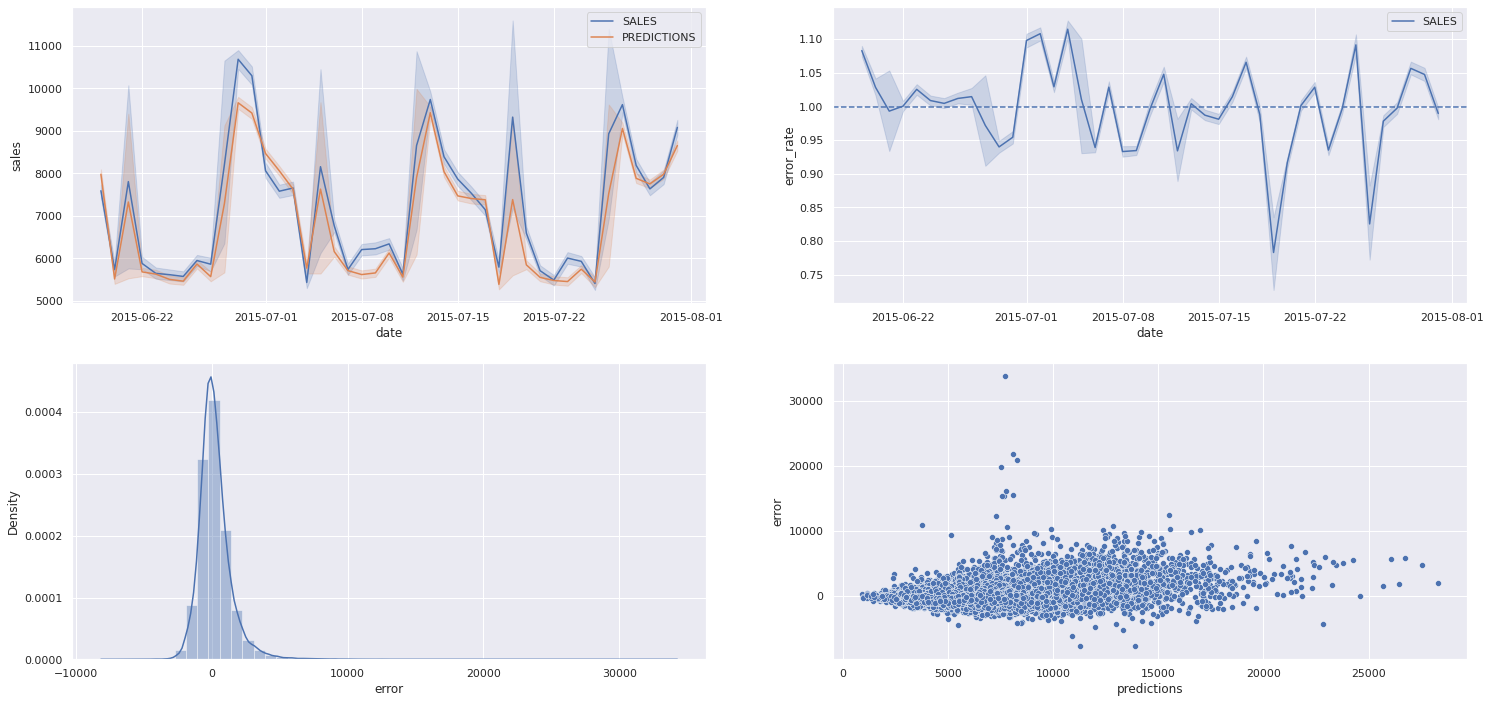

In [99]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9, label='SALES' )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [100]:
import pickle
import pandas as pd
import numpy as np
import inflection
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path                     = '/home/jocafneto/repositorio/rossmann/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb' ) )

        
    def data_cleaning( self, df1 ):

        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types

        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
    
    def feature_engineering( self, df2 ):
        ## 2.4. Feature Engineering

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    def data_preparation( self, df5 ):
        ## 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )
        
        ### 5.3.1 Encoding
        # state holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3 Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                         'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( oriente='records', data_format='iso' )

## 10.2 API Handler

In [101]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/jocafneto/repositorio/rossmann/model/model_rossmann.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', method=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_jason: # there is data
        if isinstance( test_json, dict ): # unique exemple
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple exemples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: ignored

## 10.3 API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv( '/home/jocafneto/repositorio/rossmann/data/test.csv', low_memory=False )


In [ ]:
# merge test + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
# df_test = df_test[df_test['Store'].isin( [22, 24, 12, 15, 17] )]
# df_test = df_test[df_test['Store']

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
df_test = df_test.sample(46)

In [ ]:
# convert DataFrame to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-test27.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d1.head()

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
a = 0.0

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 week'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )
    a = a + d2.loc[i, 'prediction']
    
print('The sum of Predictions is {:,.2f}'.format(a))